## Session 1: Video Frame Classifier (2019/09/14)

The objective of this session was to train a Neural Network to identify to which of two videos does a frame belong.

For this, any two videos from youtube were downloaded, and a number of frames extracted form them (around 500 form each). Then, they were resized to the same format, divided between train and test set, and stored in an array for inputing to a NN created using Keras.

This notebook was designed to run in Google Colab.

In [1]:
# Install dependencies missing in default Colab environment
!pip install pytube

# Import the necessary packages
import cv2  # OpenCV 2 for capturing frames from the video
import os  # For managing paths and directories in the project
import shutil  # High level file operations
import numpy as np  # Arrays
import keras  # High level NN API
from PIL import Image # For image processing
from pathlib import Path  # For easily managing paths
from pytube import YouTube  # For downloading videos from youtube
from IPython import display  # For displaying images inline with the notebook
from sklearn.model_selection import train_test_split  # For train-test splitting

Using TensorFlow backend.


First, we will set up a function for downloading the videos we want from the Youtube. We will be using a name:link dictionary to input the videos we want with more flexibility and to give us an easy name with which to manage it. The pytube library will take care of the download itself.

In [0]:
def download_video(video_url, video_name, path=Path("")):
    """Download video from YouTube.

    Downloads a YouTube video to the given path as mp4 file with
    the highest resolution available and names it

    Arguments:
    video_url -- string with url of the video to be downloaded
    video_name -- string with which to name the resulting file
    path -- directory Path object to which video should be saved
    """

    path = Path(path)  # Make sure we are using a pathlib Path object

    filename = video_name + ".mp4"  # Name of the video file
    final_location = path / filename

    # Download
    video = YouTube(url)  # PyTube video object for the specified url
    strm = video.streams.filter(progressive=True, file_extension="mp4")  # Available video mp4 streams for the url
    strm.order_by('resolution').desc().first().download(filename=video_name)  # Select highest resolution and download

    # Relocate
    os.renames(filename, final_location)  # Move the file to desired location, creating the folder if needed

    return None

Let's use it now to download two of the most famous (and funniest) videos in YouTube and store them in the ```data/videos``` folder.

In [0]:
videos = {"charlie": "https://www.youtube.com/watch?v=_OBlgSz8sSM", 
          "dentist": "https://www.youtube.com/watch?v=txqiwrbYGrs"}
videos_path = Path("data/videos")
for name, url in videos.items():
    download_video(url, name, path=videos_path)

Now, we have to extract frames from those videos. We will extract 500 frames from each, chosen randomly without replacement. Lets make another function to take care of this task.

In [0]:
def extract_frames(filename, num_frames=500, path=Path("")):
    """Extract randomnized frames from a video.

    Arguments:
    filname -- video file location form which to extract frames
    num_frames -- number of frames to extract, use negative for all frames
    path -- directory Path object to which frames will be saved
    """

    path = Path(path)  # Make sure we are using a pathlib Path object

    vidcap = cv2.VideoCapture(str(filename))
    video_name = os.path.splitext(os.path.basename(filename))[0]  # Get base name of the video

    if vidcap.isOpened():
        total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total number of frames in the video
        to_sample = np.random.choice(np.arange(total_frames), # Random choice of frames to extract
                                     size=num_frames, 
                                     replace=False)
        
        # Iterate over all frames and save only those in the random sample
        for i in np.arange(total_frames):
            success, image = vidcap.read()  # Read next frame in video
            if i in to_sample:  # Save it if in sample
                digits = len(str(total_frames))
                frame_name = f"{video_name}_f{str(i).zfill(digits)}.jpg"
                cv2.imwrite(frame_name, image)  # Save image
                os.renames(frame_name, path / frame_name) # Relocate to path

    else:
        print("Error opening video at " + filename)

    return None

Let's use the function to read those frames and store them on separate folders for each video, at ```data/frames```.



In [0]:
frames_path = Path("data/frames")
for video in videos.keys():
    shutil.rmtree(frames_path/video, ignore_errors=True)  # Remove images from previous run
    extract_frames(videos_path/(video+".mp4"), 
                   num_frames=500, 
                   path=frames_path/video)

We can now briefly explore our image data to check that everything is all right with the extracted frames.


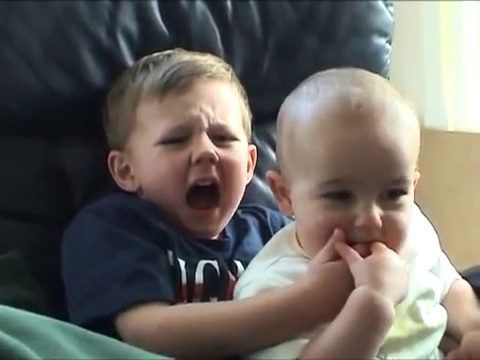

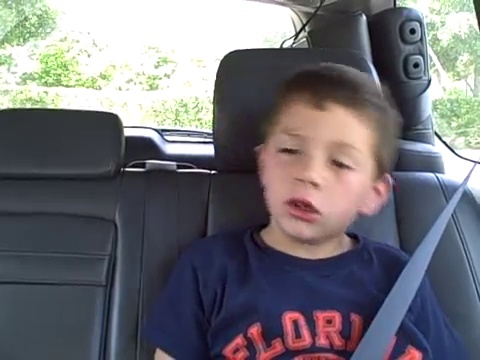

In [6]:
# Lists of all image files in each video folder
charlie_frame_list = os.listdir(frames_path/list(videos.keys())[0])
dentist_frame_list = os.listdir(frames_path/list(videos.keys())[1])

# Display the forty second frame in each folder
display.display(display.Image(filename=str(
    frames_path/list(videos.keys())[0]/charlie_frame_list[42])))

display.display(display.Image(filename=str(
    frames_path/list(videos.keys())[1]/dentist_frame_list[42])))

If everyting is OK, we can continue by interpreting all the images as arrays and gathering them in a tensor for inputing into the NN. All images will be resized to 224x224, the default input shape for the model we will be using. We will define a new function for this task.

In [0]:
def images_to_array(folder_paths, shape=(224, 224), ext=".jpg"):
    """Return a 4 dim numpy array with all images from all folders requested and
    a 1 dim array with the categories.

    Arguments:
    folder_paths -- list of folder paths to read images from
    shape -- 2-tuple with the X, Y pixel shape of the image
    ext -- extension of images to read
    """
    X = []  # Temporal list where image data will be stored
    Y = []  # Temporal list where image integer labels will be stored

    for i_label, folder_path in enumerate(folder_paths):
        folder_path = Path(folder_path)  # Make sure path is using pathlib
        image_list = os.listdir(folder_path)
        image_list = list(filter(lambda x: x.endswith(ext), image_list))  # Filter images of desired extension

        for image_name in image_list:
            image_path = folder_path / image_name
            image = Image.open(image_path)
            image_resized = image.resize(shape, Image.ANTIALIAS)

            X.append(np.asarray(image_resized))
            Y.append(i_label)

    return np.asarray(X), np.asarray(Y)

The data from the images will be sotored in X, with the images themselves, and Y, with the integer labels referring to the video they originate from.

Then, we will normalize X so that the RGB values go from 0 to 1 instead of 0 to 255, and we will change Y to a categorical set.

In [0]:
frames_folders = [frames_path/video for video in videos.keys()]

# Read the images
X, Y = images_to_array(frames_folders)

# Normalize X
X = X / 255

# Change Y to categorical
Y = keras.utils.np_utils.to_categorical(Y, len(videos))

Before proceeding with the classifier itself, we need to split our data between train and test, which is easily done thanks to a sklearn function. 

Note that the fit method in Keras provides an option for extracting the validation data from the end of the input data, but it does not shuffle the data before doing so, and therefore currently it would be picking frames from the end of the last video to be read here. In order to use that option properly, we would need to pre-shuffle X and Y together.

In [0]:
test_ratio = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=test_ratio, 
                                                    random_state=42)

With our data ready, let's build the model. We will be using [Keras](https://keras.io/), and instead of starting from scratch we will use an already existing model, [MobileNet](https://arxiv.org/pdf/1704.04861.pdf), with weights pre-trained on ImageNet for object recognition in images. Then, we will add some dense layers to the end of the network.

In [10]:
n_classes = len(videos)

# Imports the MobileNet model with ImageNet weights and discards the last (fully
# connected) layer
mobile = keras.applications.MobileNet(weights='imagenet',include_top=False)

# Build chain of layers to add until output layer is reached
x = mobile.output  # Chain from MobileNet output
x = keras.layers.GlobalAveragePooling2D()(x)  # Pooling for dimensional reduction
x = keras.layers.Dense(1024, activation='relu')(x)  # Dense layer 1 for complex feature learning
x = keras.layers.Dense(1024, activation='relu')(x)  # Dense layer 2
x = keras.layers.Dense(512,  activation='relu')(x)  # Dense layer 3
x = keras.layers.Dense(n_classes, activation='softmax')(x)  # Output layer with softmax for classification

model = keras.Model(inputs=mobile.input,outputs=x)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



17227776/17225924 [==============================] - 0s 0us/step


We can take a look at the final state of the model layers, which now include the Desde layers we added, and the softmax layers for the final classification result.

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

We compile the model with the Adam optimizer and default deffinitions for loss and metrics.

In [12]:
model.compile(optimizer = 'Adam',
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

Finally, we call the `fit` method in order to train the model. We wll use three epochs. In each epoch, the optimizer will go through every image in the training set.

In [13]:
model.fit(X_train, Y_train, validation_data=[X_test, Y_test], epochs=3, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 800 samples, validate on 200 samples
Epoch 1/3
 - 19s - loss: 0.0867 - acc: 0.9563 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/3
 - 10s - loss: 1.1958e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/3
 - 10s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000


As we can see, for such simple videos, the classifier has an almost perfect accuracy.

We can save the configuration and weights of the model for future use.

In [0]:
model.save("vf_classifier_charlie_dentist.h5")